In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


Loading the data of the [SLAC dataset](http://jmir.sourceforge.net/Codaich.html), with 250 MIDI files. The dataset is equally balanced over the classes.

The vectors are computed using [midi2vec](https://github.com/midi-ld/midi2vec).

The dataset provides 2 kind of classes (genres and subgenres), respectively of 5 and 10 elements:

- Blues
    - Modern Blues
    - Traditional Blues
- Classical
    - Baroque
    - Romantic
- Jazz
    - Bop
    - Swing
- Rap
    - Hardcore Rap
    - Pop Rap
- Rock
    - Alternative Rock
    - Metal

In [2]:
data = np.loadtxt('./dataset-slac/vectors.txt')
genres = np.loadtxt('./dataset-slac/genre.txt', dtype=np.str, delimiter=',')
subgenres = np.loadtxt('./dataset-slac/subgenre.txt', dtype=np.str, delimiter=',')

The labels are represented with the 1-hot encoding

In [3]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [4]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, short=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 8))
    n = cm.shape[1]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set( 
            xticks=np.arange(n),
            yticks=np.arange(n),
            ylim= (n-0.5, -0.5),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    fnames = ['slac', short]
    if normalize: fnames.append('norm')
    filename = 'plot/' + '_'.join(fnames) + '.pdf'
    fig.savefig(filename, dpi=fig.dpi)

### Experiment 1: Genres 

In [5]:
labels_1hot = onehot_labels(genres)
    
onehot2str(labels_1hot[0])

'Classical'

In [6]:
data.shape

(250, 100)

In [7]:
labels_1hot.shape

(250, 5)

In [8]:
num_input = data.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 5)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [9]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [11]:
random_state = 2111
scores = cross_val_score(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

W0823 16:43:03.861814 4406552000 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0823 16:43:04.056475 4406552000 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


array([0.93599999, 0.92800003, 0.89599997, 0.97600007, 0.97600001,
       0.86400002, 0.87999994, 0.91199994, 0.94399995, 0.84800005])

In [12]:
np.mean(scores)

0.9159999966621399

In [13]:
predicted = cross_val_predict(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

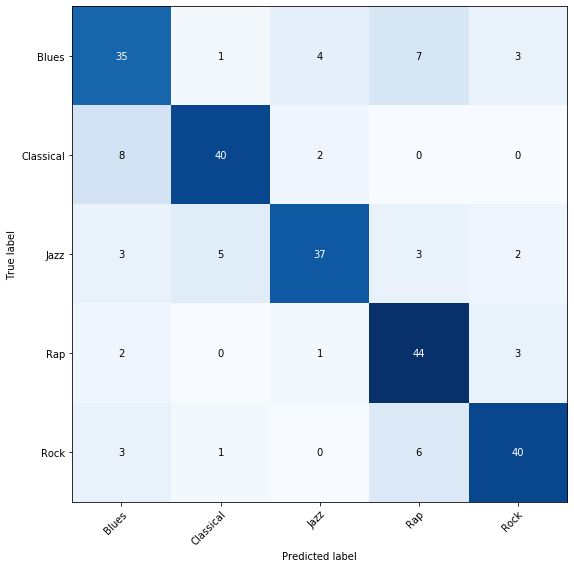

In [14]:
plot_confusion_matrix(labels_1hot, predicted, classes=genres, short='genre')

#### Normalized confusion matrix

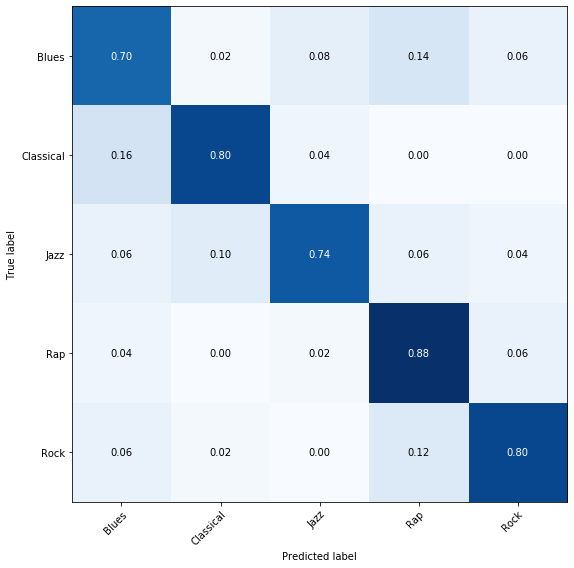

In [15]:
plot_confusion_matrix(labels_1hot, predicted, classes=genres, normalize=True, short='genre')

### Experiment 2: Subgenres 

The experiment is the same, but applied to the 10 subgenre classes.

In [16]:
labels_1hot = onehot_labels(subgenres)
    
onehot2str(labels_1hot[0])

'Romantic'

In [17]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 10)

In [18]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

In [19]:
scores = cross_val_score(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

array([0.91600001, 0.90799993, 0.91199994, 0.92800003, 0.92000002,
       0.91600007, 0.87600005, 0.93599999, 0.91600001, 0.91199994])

In [20]:
np.mean(scores)

0.9139999985694885

In [21]:
predicted = cross_val_predict(neural_network, data, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

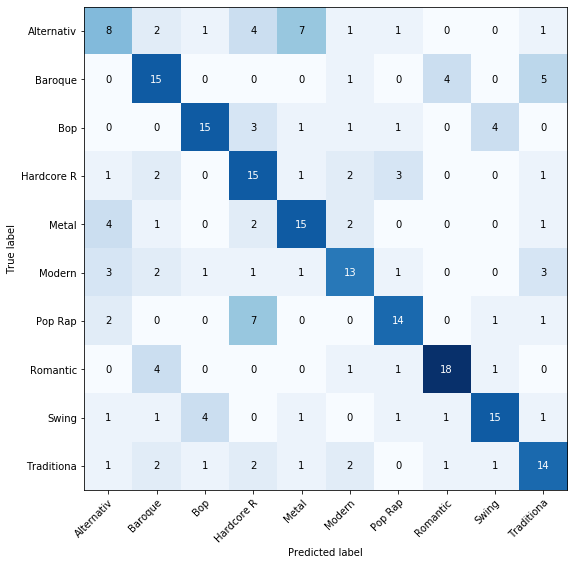

In [22]:
plot_confusion_matrix(labels_1hot, predicted, classes=subgenres, short="subgenre")

#### Normalized confusion matrix

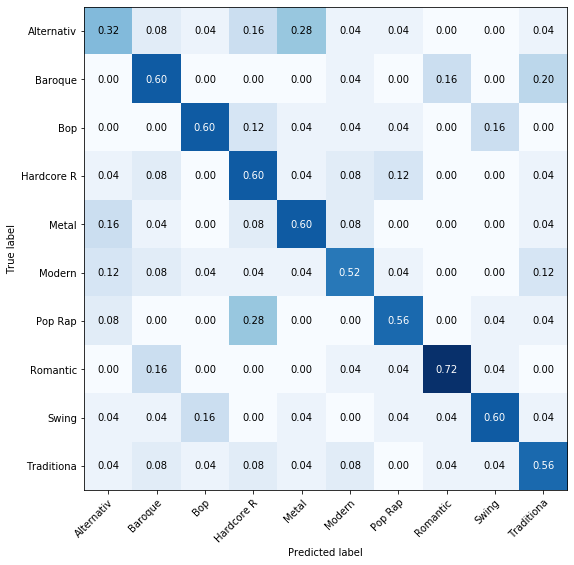

In [23]:
plot_confusion_matrix(labels_1hot, predicted, classes=subgenres, normalize=True, short="subgenre")